In [444]:
# Load the required libraries

import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import numpy as np

import plotly.express as px
import plotly.graph_objects as go

import datetime


In [445]:
#Load the dataframe
df = pd.read_csv('C:\\Users\\Aniruddha\\Documents\\Personal\\NYC_Data_Science\\Hackathon-July-2020\\NYCDSA-Hackathon-July-2020\\Products.csv')
df['Date-Added'] = pd.to_datetime(df['Date-Added'])
print(df.shape)
print(df.columns)


(168, 26)
Index(['Id', 'Price-Max', 'Price-Min', 'Availability', 'Condition',
       'Price-Currency', 'Date-Seen', 'On-Sale', 'Merchant', 'Shipping',
       'Price-Source-URLs', 'ASINS', 'Brand', 'Category-Labels', 'Date-Added',
       'Date-Updated', 'EAN', 'Image URLs', 'Keys', 'Manufacturer',
       'Manufacturer-Id', 'Name', 'Primary-Category', 'Review-Source-URLs',
       'UPC', 'Weight'],
      dtype='object')


In [446]:
# Remove erroneously priced product

df =  df[df["Price-Min"] > 1]


In [447]:

# Convert Date Seen string to datetime

df["Date-Seen"] = df["Date-Seen"].apply(lambda x: x.split(","))
df["Date-Seen"] = df["Date-Seen"].apply(lambda x: [datetime.datetime.strptime(y,"%Y-%m-%dT%H:%M:%SZ") for y in x])


In [448]:
# Bucket the products based on the average price across sellers

dfmean = df.groupby('Name').agg(AvgPrice = ('Price-Min', 'mean')).reset_index()
Low = dfmean.loc[dfmean['AvgPrice'] < 1000]['Name'].to_list()
Medium = dfmean.loc[dfmean['AvgPrice'] > 1000].loc[dfmean['AvgPrice'] < 2000]['Name'].to_list()
High = dfmean.loc[dfmean['AvgPrice'] > 2000]['Name'].to_list()
ldf = df.loc[df['Name'].isin(Low)].loc[df['Condition'] == 'New']
mdf = df.loc[df['Name'].isin(Medium)].loc[df['Condition'] == 'New']
hdf = df.loc[df['Name'].isin(High)].loc[df['Condition'] == 'New']
ldf['Label'] = 'Low'
mdf['Label'] = 'Medium'
hdf['Label'] = 'High'
df = pd.concat([pd.concat([ldf,mdf], axis = 0), hdf], axis = 0)


In [449]:
# Define fuction to collapse list elements in Date-Seen column to rows, keeping all other column values same

def splitDataFrameList(df,target_column,separator):
    ''' df = dataframe to split,
    target_column = the column containing the values to split
    separator = the symbol used to perform the split
    returns: a dataframe with each entry for the target column separated, with each element moved into a new row. 
    The values in the other columns are duplicated across the newly divided rows.
    '''
    def splitListToRows(row,row_accumulator,target_column,separator):
        for s in row[target_column]:
            new_row = row.to_dict()
            new_row[target_column] = s
            row_accumulator.append(new_row)
    new_rows = []
    df.apply(splitListToRows,axis=1,args = (new_rows,target_column,separator))
    new_df = pd.DataFrame(new_rows)
    return new_df


## Price Skimming

Price skimming is a product pricing strategy by which a firm charges the highest initial price that customers will pay and then lowers it over time. As the demand of the first customers is satisfied and competition enters the market, the firm lowers the price to attract another, more price-sensitive segment of the population.

In [511]:
# Launch date against the date when a price was first recorded for the item

data = splitDataFrameList(df, 'Date-Seen', ',') 
data = data.groupby('Name').agg({'Date-Added': ['min'], 'Date-Seen': ['min']}).reset_index()
data.columns = ['Name', 'Date-Added-Min', 'Date-Seen-Min']

fig = go.Figure(data=[go.Table(
    header=dict(values=list(data.columns),
                fill_color='paleturquoise',
                align='left'),
    cells=dict(values=[data.Name, data['Date-Added-Min'], data['Date-Seen-Min']],
               fill_color='lavender',
               align='left'))
])

fig.show()

#fig.write_image("images/fig1.png")


In [451]:
# Price variation of High End TVs

data = splitDataFrameList(df.loc[df['Label'] == 'High'][['Name', 'Price-Min', 'Date-Seen', 'Date-Added']], 'Date-Seen', ',')

colorsIdx = {'Sony - 55 class - oled - a1e series - 2160p - smart - 4k uhd tv with hdr"': 'rgb(215,48,39)', 
             'Samsung - 55 class - led - q8f series - 2160p - smart - 4k uhd tv with hdr"': 'rgb(228, 247, 15)',
             'Samsung - 55 class - led - curved - q7c series - 2160p - smart - 4k uhd tv with hdr"': 'rgb(39, 60, 215)'}
cols      = data['Name'].map(colorsIdx)

fig = go.Figure()
fig.add_trace(go.Scatter(
    x = data['Date-Seen'],
    y = data['Price-Min'],
    text=data['Name'],
    mode = 'markers',
    marker=dict(size=10, color=cols)))
fig.update_layout(title='Price Variation with Time',
                 xaxis_title="Date",
                 yaxis_title="Price")

fig.show()

#fig.write_image("images/fig2.png")


In [452]:
# Price variation of Mid-Range TVs

data = splitDataFrameList(df.loc[df['Label'] == 'Medium'][['Name', 'Price-Min', 'Date-Seen', 'Date-Added']], 'Date-Seen', ',')

colorsIdx = {'X900f-series 55-class hdr uhd smart led tv': 'rgb(39, 60, 215)',
             'Sony - 55 class - led - x800e series - 2160p - smart - 4k uhd tv with hdr"': 'rgb(29, 222, 206)'}
cols      = data['Name'].map(colorsIdx)

fig = go.Figure()
fig.add_trace(go.Scatter(
    x = data['Date-Seen'],
    y = data['Price-Min'],
    text=data['Name'],
    mode = 'markers',
    marker=dict(size=10, color=cols)
))
fig.update_layout(title='Price Variation with Time',
                 xaxis_title="Date",
                 yaxis_title="Price")

fig.show()

#fig.write_image("images/fig3.png")


In [512]:
# Price variation of Low-Range TVs

data = splitDataFrameList(df.loc[df['Label'] == 'Low'][['Name', 'Price-Min', 'Date-Seen', 'Date-Added']], 'Date-Seen', ',')

colorsIdx = {'Hisense - 55 class - led - h9 series - 2160p - smart - 4k uhd tv with hdr"': 'rgb(215,48,39)', 
             'Samsung 55 class 4k (2160p) smart led tv (un55ku7000)"': 'rgb(228, 247, 15)',
             'Samsung - 55 class - led - curved - mu6490 series - 2160p - smart - 4k ultra hd tv with hdr"': 'rgb(39, 60, 215)',
             'Lg - 55 class - led - uj7700 series - 2160p - smart - 4k uhd tv with hdr"': 'rgb(37, 196, 37)',
             'Hisense - 55 class - led - h8 series - 2160p - smart - 4k uhd tv with hdr"': 'rgb(76, 77, 73)',
             'Sony xbr55x700d 55-inch 4k ultra hd smart led tv (2016 model)': 'rgb(222, 29, 203)'}
cols      = data['Name'].map(colorsIdx)

fig = go.Figure()
fig.add_trace(go.Scatter(
    x = data['Date-Seen'],
    y = data['Price-Min'],
    text=data['Name'],
    mode = 'markers',
    marker=dict(size=10, color=cols)
))
fig.update_layout(title='Price Variation with Time',
                 xaxis_title="Date",
                 yaxis_title="Price")

fig.show()

#fig.write_image("images/fig4.png")


In [454]:
# Check if the product is in stock in other platforms
data = df.loc[df['Availability'] == 'In Stock'].groupby(['Name', 'Merchant']).agg('size').reset_index()
data.columns = ['Name', 'Merchant', 'Count']

fig = px.bar(data, x="Name", y="Count", color="Merchant", title="Product Availability across Merchants/Platform")
fig.show()

#fig.write_image("images/fig5.png")


In [455]:
# Check for products and the duration for which they have held on to a price point

def datediff(row):
    dates = []
    maxd = max(d for d in row['Date-Seen'])
    mind = min(d for d in row['Date-Seen'])
    return (maxd - mind).days

data = df.copy()
data['Days-Seen'] = data.apply(datediff,axis=1)
dt = pd.merge(data.loc[data['On-Sale'] == False].groupby(['Name', 'Label']).agg(Days_Regular = ('Days-Seen','max')).reset_index(), 
         data.loc[data['On-Sale'] == True].groupby(['Name', 'Label']).agg(Days_Sale = ('Days-Seen','max')).reset_index(), 
         how='inner', on = ['Name', 'Label'])
data = pd.merge(dt, data.groupby(['Name', 'Label']).agg(['min', 'max'])['Price-Min'].reset_index(), 
                how='inner', on = ['Name','Label']).sort_values(by='Label')

fig = go.Figure(data=[
    go.Bar(name='Regular', x=data.Name, y=data['Days_Regular']),
    go.Bar(name='Sale', x=data.Name, y=data['Days_Sale'])
])

fig.update_layout(barmode='group')
fig.show()

#fig.write_image("images/fig6.png")


## Value-Based Pricing

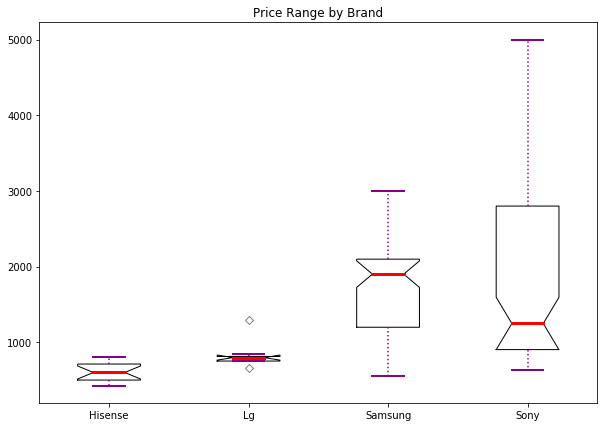

In [458]:
# Check the pricing by brand

data = df.groupby('Brand')['Price-Min'].apply(list)
fig, ax = plt.subplots(figsize =(10, 7))
bp = ax.boxplot(data, notch ='True')
ax.set_xticklabels(['Hisense', 'Lg',  
                    'Samsung', 'Sony'])
plt.title("Price Range by Brand") 
colors = ['#0000FF', '#00FF00',  
          '#FFFF00', '#FF00FF'] 

for whisker in bp['whiskers']: 
    whisker.set(color ='#8B008B', 
                linewidth = 1.5, 
                linestyle =":")
for cap in bp['caps']: 
    cap.set(color ='#8B008B', 
            linewidth = 2)
for median in bp['medians']: 
    median.set(color ='red', 
               linewidth = 3)
for flier in bp['fliers']: 
    flier.set(marker ='D', 
              color ='#e7298a', 
              alpha = 0.5)
plt.show(bp)

In [504]:
# Average review across price buckets

colors = ['lightslategray',] * 5
colors[2] = 'crimson'

fig = go.Figure(data=[go.Bar(
    x=['Low-Range', 'Mid-Range', 'High-Range'],
    y=[4.45, 4.5, 4.75],
    marker_color=colors,
    text=score,
    textposition='auto' 
)])

fig.update_layout(title_text='Average reviews across price-points')
fig.show()

#fig.write_image("images/fig8.png")


FileNotFoundError: [Errno 2] No such file or directory: 'images/fig2.png'

In [502]:
# Product features at price-points

fig = go.Figure(data=[go.Table(
    header=dict(values=['High-Range', 'Mid-Range', 'Low-Range'],
            line_color='darkslategray',
            fill_color='lightskyblue',
            align='left'),
    cells=dict(values=[['OLED', 'HDR10', 'Backlight LED', '120-240 Hz Refresh Rate'], 
                       ['LED', 'HDR', 'Supreme UHD Dimming', '80-120 Hz Refresh Rate'],
                       ['LED', 'UHD Dimming', '60 Hz Refresh Rate']],
               line_color='darkslategray',
               fill_color='lightcyan',
               align='left'))
])

fig.show()

#fig.write_image("images/fig9.png")


In [498]:
# Shipping Cost across price buckets

data = df.dropna(subset=['Shipping'])
data = data.groupby(['Label', 'Shipping']).agg('size').reset_index()
data.columns = ['Label', 'Shipping', 'Count']

fig = go.Figure(data=[go.Table(
    header=dict(values=list(data.columns),
                fill_color='paleturquoise',
                align='left'),
    cells=dict(values=[data.Label, data.Shipping, data.Count],
               fill_color='lavender',
               align='left'))
])

fig.show()

#fig.write_image("images/fig10.png")
